In [73]:
import numpy as numpy
import pandas as pd 


In [74]:
import os
os.path.abspath(os.getcwd())

'e:\\Alireza\\Uppsala\\Classes\\Data_Mining\\Project'

In [75]:
df = pd.read_csv("European_citiznes_rsvp.csv")
df.count()
df.dropna()

COUNTRY  SEX    YEAR  life_expectancy  \
0    Austria  ALL  2000.0            78.47   
1    Austria  ALL  2001.0            78.95   
2    Austria  ALL  2002.0            79.01   
3    Austria  ALL  2003.0            78.89   
4    Austria  ALL  2004.0            79.43   
..       ...  ...     ...              ...   
553   Sweden  ALL  2018.0            82.71   
554   Sweden  ALL  2019.0            83.22   
555   Sweden  ALL  2020.0            82.46   
556   Sweden  ALL  2021.0            83.26   
557   Sweden  ALL  2022.0            83.24   

     average_number_of_calories_available_per_person_per_day  \
0                                               2223.0         
1                                               2242.0         
2                                               2156.0         
3                                               2270.0         
4                                               2254.0         
..                                                 ...         
553                                             3411.0         
554                                             3450.0         
555                                             3466.0         
556                                             3527.0         
557                                             3517.0         

     unemployment_rate  regular_daily_smokers  adult_overweight  \
0                  5.6                   29.5             33.30   
1                  5.1                   40.1             33.80   
2                  3.6                   24.7             34.20   
3                  4.4                   34.9             34.70   
4                  5.7                   39.0             35.10   
..                 ...                    ...               ...   
553                6.2                   18.4             52.23   
554                7.9                   15.9             52.76   
555               11.5                   33.0             53.29   
556               14.4                   29.0             53.80   
557               16.2                   28.0             54.32   

     alcahol_consumption_liter_per_capita  fat_available_ppd  protein_ppd  \
0                                    1.17              44.85        66.11   
1                                    0.91              46.06        66.12   
2                                    1.04              43.14        64.58   
3                                    1.04              48.29        65.59   
4                                    1.03              44.41        66.63   
..                                    ...                ...          ...   
553                                  9.00             138.58        96.73   
554                                  9.12             138.96        96.96   
555                                  9.06             140.72        99.18   
556                                  9.36             146.00       102.49   
557                                 10.18             144.11       101.28   

     average_fruit_vegtable_ppd  
0                        128.80  
1                        121.44  
2                        115.27  
3                        127.38  
4                        120.52  
..                          ...  
553                      175.32  
554                      173.29  
555                      172.22  
556                      169.74  
557                      168.94  

[558 rows x 12 columns]

In [76]:
import pandas as pd
import numpy as np

summary = {
    "n_rows": len(df),
    "n_countries": df["COUNTRY"].nunique(),
    "years_min": df["YEAR"].min(),
    "years_max": df["YEAR"].max(),
    "sex_levels": df["SEX"].unique().tolist(),
}
missing = df.isna().mean().sort_values(ascending=False)  # share missing per column

# 2) Per-country trend features (slopes and percent change)
def slope(y, x):
    if len(y.dropna()) < 3: return np.nan
    x = x.astype(float)
    y = y.astype(float)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m

trend_cols = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
    "unemployment_rate",
]

# Work on total (collapse SEX if you have both M/F): take average across SEX within country-year
df_tot = (df.groupby(["COUNTRY","YEAR"], as_index=False)
            [trend_cols].mean())

# Slopes per country
slopes = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
          .reset_index())

# Percent change 2002 -> 2022
def pct_change_2002_2022(g, col):
    g = g.sort_values("YEAR")
    first = g.loc[g["YEAR"].idxmin(), col] if not g.empty else np.nan
    last  = g.loc[g["YEAR"].idxmax(), col] if not g.empty else np.nan
    return (last - first) / first * 100 if pd.notna(first) and first != 0 else np.nan

pctchg = (df_tot
          .groupby("COUNTRY")
          .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))
          .reset_index())

trend_table = slopes.merge(pctchg, on="COUNTRY", how="outer")

# 3) Associations with life expectancy
# 3a) Overall Pearson correlations (latest year only, e.g., 2022)
latest_year = df_tot["YEAR"].max()
snap = df_tot[df_tot["YEAR"] == latest_year].copy()
corr_cols = ["life_expectancy","average_number_of_calories_available_per_person_per_day",
             "regular_daily_smokers","adult_overweight","alcahol_consumption_liter_per_capita",
             "fat_available_ppd","protein_ppd","average_fruit_vegtable_ppd","unemployment_rate"]
corr_latest = snap[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 3b) Within-country correlations (demeaned by country)
def demean_by_country(d, cols):
    return d.assign(**{c: d[c] - d.groupby("COUNTRY")[c].transform("mean") for c in cols})
dm = demean_by_country(df_tot, corr_cols)
corr_within = dm[corr_cols].corr().loc["life_expectancy"].sort_values(ascending=False)

# 4) Quick fixed-effects style regression (no external libs)
# life_expectancy ~ calories + smokers + alcohol + unemployment + year FE
X_cols = ["average_number_of_calories_available_per_person_per_day",
          "regular_daily_smokers","alcahol_consumption_liter_per_capita",
          "unemployment_rate"]
d = df_tot.dropna(subset=["life_expectancy"] + X_cols).copy()
# Add year dummies
year_dummies = pd.get_dummies(d["YEAR"], prefix="Y", drop_first=True)
X = pd.concat([d[X_cols], year_dummies], axis=1)
X = (X - X.mean())/X.std(ddof=0)  # scale for comparability
X["intercept"] = 1.0
y = d["life_expectancy"].astype(float)

# OLS via closed form
XtX = X.T @ X
Xty = X.T @ y
beta = np.linalg.pinv(XtX) @ Xty
coef = pd.Series(beta, index=X.columns).sort_values(ascending=False)

# 5) Country profiles (latest year z-scores)
Z = snap.copy()
for c in corr_cols:
    Z[c + "_z"] = (Z[c] - Z[c].mean()) / Z[c].std(ddof=0)
country_profile = Z[["COUNTRY"] + [c+"_z" for c in corr_cols]]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25708\3611628942.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_slope": slope(g[c], g["YEAR"]) for c in trend_cols}))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25708\3611628942.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({f"{c}_pctchg": pct_change_2002_2022(g, c) for c in trend_cols}))


In [77]:
missing

COUNTRY                                                    0.0
SEX                                                        0.0
YEAR                                                       0.0
life_expectancy                                            0.0
average_number_of_calories_available_per_person_per_day    0.0
unemployment_rate                                          0.0
regular_daily_smokers                                      0.0
adult_overweight                                           0.0
alcahol_consumption_liter_per_capita                       0.0
fat_available_ppd                                          0.0
protein_ppd                                                0.0
average_fruit_vegtable_ppd                                 0.0
dtype: float64

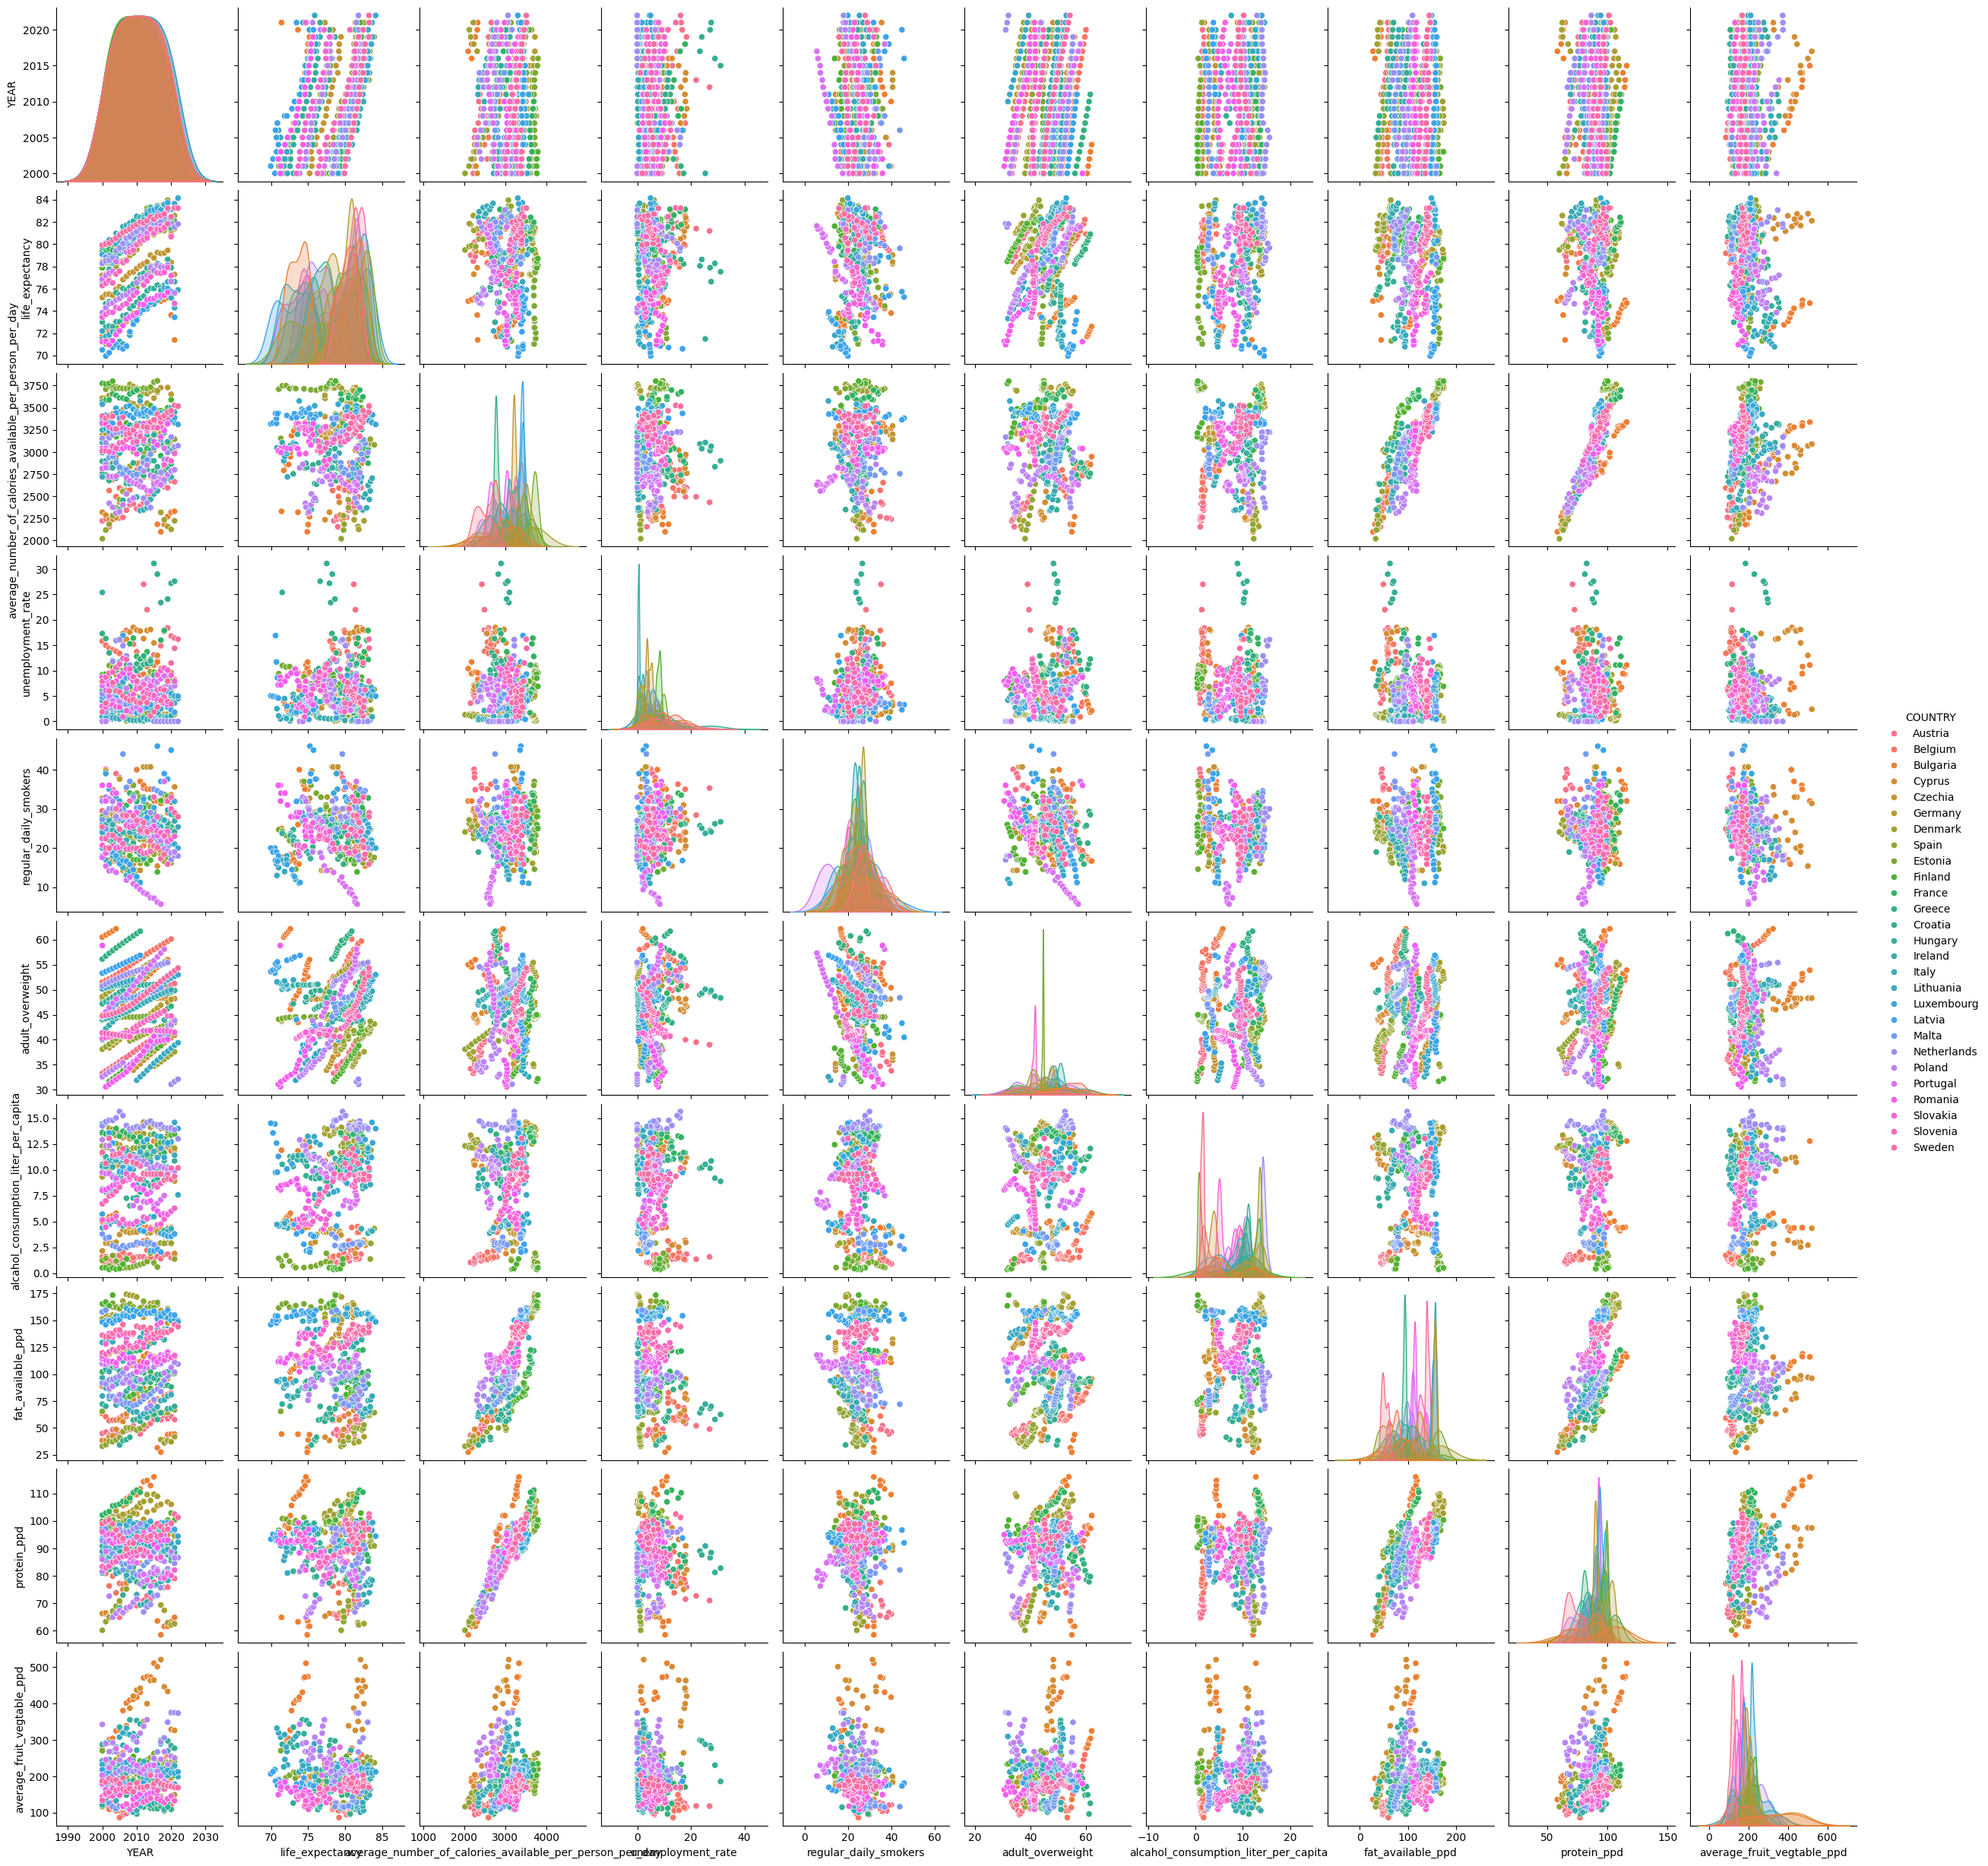

In [78]:
import seaborn as sns
sns.pairplot(df,hue="COUNTRY")

In [79]:
import numpy as np 
cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
]

for col in cols_to_bin:

    Q1 = np.percentile(df[f"{col}"], 25, interpolation = 'midpoint') 
    Q2 = np.percentile(df[f"{col}"], 50, interpolation = 'midpoint') 
    Q3 = np.percentile(df[f"{col}"], 75, interpolation = 'midpoint') 
    
    print('Q1 25 percentile of the given data is, ', Q1)
    print('Q1 50 percentile of the given data is, ', Q2)
    print('Q1 75 percentile of the given data is, ', Q3)

    IQR = Q3 - Q1 
    print('Interquartile range is', IQR)
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    print('low_limit is', low_lim)
    print('up_limit is', up_lim)
    outlier =[]
    for x in df[f"{col}"]:
        if ((x> up_lim) or (x<low_lim)):
            print(f"{col} had outlienr")
            outlier.append(x)

    print(' outlier in the dataset is', len(outlier))

Q1 25 percentile of the given data is,  75.89
Q1 50 percentile of the given data is,  79.33
Q1 75 percentile of the given data is,  81.345
Interquartile range is 5.454999999999998
low_limit is 67.70750000000001
up_limit is 89.5275
 outlier in the dataset is 0
Q1 25 percentile of the given data is,  2784.5
Q1 50 percentile of the given data is,  3117.5
Q1 75 percentile of the given data is,  3378.5
Interquartile range is 594.0
low_limit is 1893.5
up_limit is 4269.5
 outlier in the dataset is 0
Q1 25 percentile of the given data is,  2.635
Q1 50 percentile of the given data is,  5.3
Q1 75 percentile of the given data is,  8.45
Interquartile range is 5.8149999999999995
low_limit is -6.0875
up_limit is 17.1725
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemployment_rate had outlienr
unemp

In [80]:
from scipy import stats
stats.zscore(df["life_expectancy"]).min()

np.float64(-2.5326224223821825)

In [81]:
data=df.copy()
data.COUNTRY.drop


<bound method Series.drop of 0      Austria
1      Austria
2      Austria
3      Austria
4      Austria
        ...   
553     Sweden
554     Sweden
555     Sweden
556     Sweden
557     Sweden
Name: COUNTRY, Length: 558, dtype: object>

In [82]:
data . drop ([ 'COUNTRY'] , axis =1 , inplace = True )


In [83]:
import pandas as pd
import numpy as np


def tertile_labels(s):
   
    return pd.qcut(s.rank(method="first"), q=3, labels=["LOW","MID","HIGH"])

cols_to_bin = [
    "life_expectancy",
    "average_number_of_calories_available_per_person_per_day",
    "unemployment_rate",
    "regular_daily_smokers",
    "adult_overweight",
    "alcahol_consumption_liter_per_capita",
    "fat_available_ppd",
    "protein_ppd",
    "average_fruit_vegtable_ppd",
]

for c in cols_to_bin:
    df[c+"_bin"] = df.groupby("YEAR")[c].transform(tertile_labels)

# Build a string item for each binned column
rename_map = {
    "life_expectancy_bin": "LIFEEXP",
    "average_number_of_calories_available_per_person_per_day_bin": "CALORIES",
    "unemployment_rate_bin": "UNEMP",
    "regular_daily_smokers_bin": "SMOKING",
    "adult_overweight_bin": "OVERWT",
    "alcahol_consumption_liter_per_capita_bin": "ALCOHOL",
    "fat_available_ppd_bin": "FAT",
    "protein_ppd_bin": "PROTEIN",
    "average_fruit_vegtable_ppd_bin": "FRUITVEG",
}

item_cols = [c+"_bin" for c in cols_to_bin]
print(item_cols)

def row_to_items(row):
    items = []
    for c in item_cols:
        label = str(row[c])
        var = rename_map[c]
        items.append(f"{var}={label}")
    return items

# 1 transaction = one (COUNTRY, YEAR)
tx_df = (df.sort_values(["COUNTRY","YEAR"])
           .dropna(subset=item_cols)
           .drop_duplicates(subset=["COUNTRY","YEAR"]))

transactions = tx_df.apply(row_to_items, axis=1).tolist()
num_records = len(transactions)
print("Transactions:", num_records)


['life_expectancy_bin', 'average_number_of_calories_available_per_person_per_day_bin', 'unemployment_rate_bin', 'regular_daily_smokers_bin', 'adult_overweight_bin', 'alcahol_consumption_liter_per_capita_bin', 'fat_available_ppd_bin', 'protein_ppd_bin', 'average_fruit_vegtable_ppd_bin']
Transactions: 558


In [84]:
df

COUNTRY  SEX    YEAR  life_expectancy  \
0    Austria  ALL  2000.0            78.47   
1    Austria  ALL  2001.0            78.95   
2    Austria  ALL  2002.0            79.01   
3    Austria  ALL  2003.0            78.89   
4    Austria  ALL  2004.0            79.43   
..       ...  ...     ...              ...   
553   Sweden  ALL  2018.0            82.71   
554   Sweden  ALL  2019.0            83.22   
555   Sweden  ALL  2020.0            82.46   
556   Sweden  ALL  2021.0            83.26   
557   Sweden  ALL  2022.0            83.24   

     average_number_of_calories_available_per_person_per_day  \
0                                               2223.0         
1                                               2242.0         
2                                               2156.0         
3                                               2270.0         
4                                               2254.0         
..                                                 ...         
553                                             3411.0         
554                                             3450.0         
555                                             3466.0         
556                                             3527.0         
557                                             3517.0         

     unemployment_rate  regular_daily_smokers  adult_overweight  \
0                  5.6                   29.5             33.30   
1                  5.1                   40.1             33.80   
2                  3.6                   24.7             34.20   
3                  4.4                   34.9             34.70   
4                  5.7                   39.0             35.10   
..                 ...                    ...               ...   
553                6.2                   18.4             52.23   
554                7.9                   15.9             52.76   
555               11.5                   33.0             53.29   
556               14.4                   29.0             53.80   
557               16.2                   28.0             54.32   

     alcahol_consumption_liter_per_capita  fat_available_ppd  ...  \
0                                    1.17              44.85  ...   
1                                    0.91              46.06  ...   
2                                    1.04              43.14  ...   
3                                    1.04              48.29  ...   
4                                    1.03              44.41  ...   
..                                    ...                ...  ...   
553                                  9.00             138.58  ...   
554                                  9.12             138.96  ...   
555                                  9.06             140.72  ...   
556                                  9.36             146.00  ...   
557                                 10.18             144.11  ...   

     average_fruit_vegtable_ppd  life_expectancy_bin  \
0                        128.80                 HIGH   
1                        121.44                 HIGH   
2                        115.27                 HIGH   
3                        127.38                 HIGH   
4                        120.52                 HIGH   
..                          ...                  ...   
553                      175.32                 HIGH   
554                      173.29                 HIGH   
555                      172.22                 HIGH   
556                      169.74                 HIGH   
557                      168.94                 HIGH   

    average_number_of_calories_available_per_person_per_day_bin  \
0                                                  LOW            
1                                                  LOW            
2                                                  LOW            
3                                                  LOW            
4                                        

In [85]:
import pyfpgrowth

# Choose minimum support as a COUNT like in your sheet:
# Example: require that an itemset appears in at least 20% of all (country,year) rows
min_support_frac = 0.10
sigma = max(1, int(np.floor(min_support_frac * num_records)))
print("Minimum support (count) =", sigma)

patterns = pyfpgrowth.find_frequent_patterns(transactions, sigma)
print("Frequent itemsets found:", len(patterns))

# Quick peek at biggest itemsets found

max_itemset_size=max(len(iset) for iset in patterns) 
print("Max frequent itemset size:", max_itemset_size)


Minimum support (count) = 55
Frequent itemsets found: 262
Max frequent itemset size: 4


In [86]:
min_conf=0.4
raw_rules=pyfpgrowth.generate_association_rules(patterns, min_conf) 

In [ ]:
raw_rules

{('FAT=HIGH', 'PROTEIN=HIGH'): (('CALORIES=HIGH',), 0.9478260869565217),
 ('FAT=HIGH', 'UNEMP=MID'): (('CALORIES=HIGH',), 0.7954545454545454),
 ('CALORIES=HIGH', 'UNEMP=MID'): (('FAT=HIGH',), 0.8235294117647058),
 ('CALORIES=HIGH', 'FAT=HIGH', 'PROTEIN=HIGH'): (('FRUITVEG=MID',),
  0.6238532110091743),
 ('CALORIES=HIGH', 'FAT=HIGH', 'UNEMP=MID'): (('PROTEIN=HIGH',), 0.8),
 ('CALORIES=HIGH', 'PROTEIN=HIGH', 'UNEMP=MID'): (('FAT=HIGH',),
  0.8115942028985508),
 ('FAT=HIGH', 'PROTEIN=HIGH', 'UNEMP=MID'): (('CALORIES=HIGH',),
  0.9824561403508771),
 ('CALORIES=HIGH', 'PROTEIN=HIGH'): (('FAT=HIGH',), 0.7218543046357616),
 ('CALORIES=HIGH',): (('FAT=HIGH',), 0.7591623036649214),
 ('CALORIES=HIGH', 'FAT=HIGH'): (('ALCOHOL=HIGH',), 0.4206896551724138),
 ('CALORIES=LOW', 'SMOKING=MID'): (('PROTEIN=LOW',), 0.9552238805970149),
 ('PROTEIN=LOW', 'SMOKING=MID'): (('CALORIES=LOW',), 0.8421052631578947),
 ('CALORIES=LOW', 'LIFEEXP=MID'): (('PROTEIN=LOW',), 0.8333333333333334),
 ('LIFEEXP=MID', 'PROTE

In [88]:
from collections import Counter
import pandas as pd

rows = []
N = len(transactions)

for antecedent, (consequent, confidence) in raw_rules.items():
    # --- Normalize antecedent ---
    if isinstance(antecedent, (list, tuple, set, frozenset)):
        antecedent = {str(x) for x in antecedent}
    else:
        antecedent = {str(antecedent)}

    # --- Normalize consequent ---
    if isinstance(consequent, (list, tuple, set, frozenset)):
        consequent = {str(x) for x in consequent}
    else:
        consequent = {str(consequent)}

    union = antecedent | consequent

    # --- Support of union (antecedent+consequent) ---
    supp_union = sum(1 for basket in transactions if union.issubset(basket)) / N

    # --- Support of consequent ---
    supp_conseq = sum(1 for basket in transactions if consequent.issubset(basket)) / N

    # --- Lift ---
    lift = confidence / supp_conseq if supp_conseq > 0 else None

    rows.append({
        "antecedent": tuple(sorted(antecedent)),
        "consequent": tuple(sorted(consequent)),
        "support": supp_union,
        "confidence": confidence,
        "lift": lift
    })

rules_df = pd.DataFrame(rows).sort_values(["lift","confidence","support"], ascending=False)


In [89]:
rules_df 

antecedent                   consequent  \
33               (CALORIES=LOW, LIFEEXP=HIGH)       (FAT=LOW, PROTEIN=LOW)   
38                (LIFEEXP=HIGH, PROTEIN=LOW)      (CALORIES=LOW, FAT=LOW)   
28                    (CALORIES=LOW, FAT=LOW)  (FRUITVEG=LOW, PROTEIN=LOW)   
42  (CALORIES=LOW, LIFEEXP=HIGH, PROTEIN=LOW)                   (FAT=LOW,)   
46      (CALORIES=LOW, FAT=LOW, FRUITVEG=LOW)               (PROTEIN=LOW,)   
..                                        ...                          ...   
39                (CALORIES=LOW, PROTEIN=LOW)              (FRUITVEG=LOW,)   
18                            (LIFEEXP=HIGH,)              (ALCOHOL=HIGH,)   
19                (CALORIES=MID, PROTEIN=MID)                 (UNEMP=LOW,)   
9                   (CALORIES=HIGH, FAT=HIGH)              (ALCOHOL=HIGH,)   
27                              (UNEMP=HIGH,)               (OVERWT=HIGH,)   

     support  confidence      lift  
33  0.116487    0.902778  4.095528  
38  0.116487    0.915493  3.929577  
28  0.132616    0.569231  3.025055  
42  0.116487    1.000000  2.983957  
46  0.132616    0.986667  2.944171  
..       ...         ...       ...  
39  0.163082    0.561728  1.676173  
18  0.173835    0.507853  1.483676  
19  0.098566    0.458333  1.367647  
9   0.109319    0.420690  1.229031  
27  0.137993    0.403141  1.177764  

[61 rows x 5 columns]

In [90]:
rules_df["support"].max()

np.float64(0.25985663082437277)

In [91]:
rules_df["lift"]

33    4.095528
38    3.929577
28    3.025055
42    2.983957
46    2.944171
        ...   
39    1.676173
18    1.483676
19    1.367647
9     1.229031
27    1.177764
Name: lift, Length: 61, dtype: float64

In [92]:
df_filtered = rules_df.query('lift >3')
df_filtered


antecedent                   consequent   support  \
33  (CALORIES=LOW, LIFEEXP=HIGH)       (FAT=LOW, PROTEIN=LOW)  0.116487   
38   (LIFEEXP=HIGH, PROTEIN=LOW)      (CALORIES=LOW, FAT=LOW)  0.116487   
28       (CALORIES=LOW, FAT=LOW)  (FRUITVEG=LOW, PROTEIN=LOW)  0.132616   

    confidence      lift  
33    0.902778  4.095528  
38    0.915493  3.929577  
28    0.569231  3.025055

In [93]:
# # Build support(count) lookups for singletons and itemsets
# from collections import Counter

# # support count for any itemset = min support among its subsets is NOT generally true;
# # we compute singleton supports directly; itemset supports come from `patterns`.
# singleton_counts = Counter()
# for basket in transactions:
#     for item in set(basket):
#         singleton_counts[item] += 1

# # Turn dict of patterns into an easy lookup
# # patterns: dict {frozenset(items): support_count}
# itemset_support = {frozenset(k): v for k, v in patterns.items()}

# # Generate rules with min confidence (e.g., 0.6)
# min_conf = 0.6
# raw_rules = pyfpgrowth.generate_association_rules(patterns, min_conf)

# # Convert to a tidy DataFrame with support & lift
# import itertools

# rows = []
# N = num_records

# for antecedent, (consequent, confidence) in raw_rules.items():
#     antecedent = frozenset(antecedent)
#     consequent = frozenset(consequent if isinstance(consequent, (list,set,frozenset)) else [consequent])
#     union = antecedent | consequent

#     supp_union = itemset_support.get(union, 0) / N
#     supp_conseq = (
#         (itemset_support.get(consequent, 0) / N)
#         if consequent in itemset_support
#         else (min(singleton_counts[i] for i in consequent) / N)  # lower bound if not stored
#     )
#     lift = (confidence / supp_conseq) if supp_conseq > 0 else np.nan

#     rows.append({
#         "antecedent": tuple(sorted(antecedent)),
#         "consequent": tuple(sorted(consequent)),
#         "support": supp_union,
#         "confidence": confidence,
#         "lift": lift,
#         "len_ante": len(antecedent),
#         "len_cons": len(consequent)
#     })

# import pandas as pd
# rules_df = pd.DataFrame(rows).sort_values(["lift","confidence","support"], ascending=False)


In [94]:
# def is_health_consequent(tup):
#     return any(x.startswith(("LIFEEXP=","OVERWT=")) for x in tup)

# rules_health = rules_df[rules_df["consequent"].apply(is_health_consequent)].copy()

# # Example reporting filters
# rules_top = (rules_health
#              .query("lift > 1.2 and confidence >= 0.6 and support >= 0.15")
#              .head(20))

# # Split into "protective" (good) and "risk" (bad) for readability
# protective = rules_top[rules_top["consequent"].apply(lambda t: any(x.endswith("HIGH") and x.startswith("LIFEEXP") or x.endswith("LOW") and x.startswith("OVERWT") for x in t))]
# risk = rules_top[rules_top["consequent"].apply(lambda t: any(x.endswith("LOW") and x.startswith("LIFEEXP") or x.endswith("HIGH") and x.startswith("OVERWT") for x in t))]

# print("=== Protective rules (examples) ===")
# print(protective[["antecedent","consequent","support","confidence","lift"]].to_string(index=False))

# print("\n=== Risk rules (examples) ===")
# print(risk[["antecedent","consequent","support","confidence","lift"]].to_string(index=False))


In [95]:
data . drop ([ 'SEX'] , axis =1 , inplace = True )

In [96]:
from sklearn . preprocessing import MinMaxScaler
minmax_scaled = MinMaxScaler().fit_transform (data)

In [97]:
from sklearn . decomposition import PCA
pca = PCA ()
principal_component=pca.fit_transform(data)

In [98]:
print(pca.explained_variance_ratio_)

[9.64950944e-01 3.13169497e-02 2.55945272e-03 3.24845499e-04
 2.54464548e-04 2.21367353e-04 1.38138765e-04 1.10993522e-04
 7.62967292e-05 4.65476467e-05]


In [99]:
principal_component

array([[-8.56188173e+02, -5.02363669e+01,  5.03563975e-01, ...,
        -4.37141190e+00,  1.16081113e+00,  3.42221214e+00],
       [-8.37391240e+02, -5.83206693e+01, -2.48228705e-01, ...,
        -4.46972255e+00, -2.17520260e-01,  3.33561114e+00],
       [-9.23532563e+02, -6.17145334e+01,  3.52610006e+00, ...,
        -5.21369319e+00,  9.50453383e-01,  3.51734212e+00],
       ...,
       [ 3.91686191e+02, -4.55479101e+01,  1.46735820e+00, ...,
         8.95709094e-01,  7.40162572e-02,  5.05096675e-01],
       [ 4.52860667e+02, -4.98440321e+01,  1.77498467e+00, ...,
         8.63069909e-01,  2.79731388e+00,  8.69804978e-01],
       [ 4.42698247e+02, -5.02696230e+01,  5.88091863e-01, ...,
         2.21874342e+00,  2.67735803e+00,  3.56793881e-01]])

Mean: 3074.6367741935487
Variance: 156411.2118053648
Standard Deviation: 395.48857354589245


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25708\3712869183.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(X, shade=True)


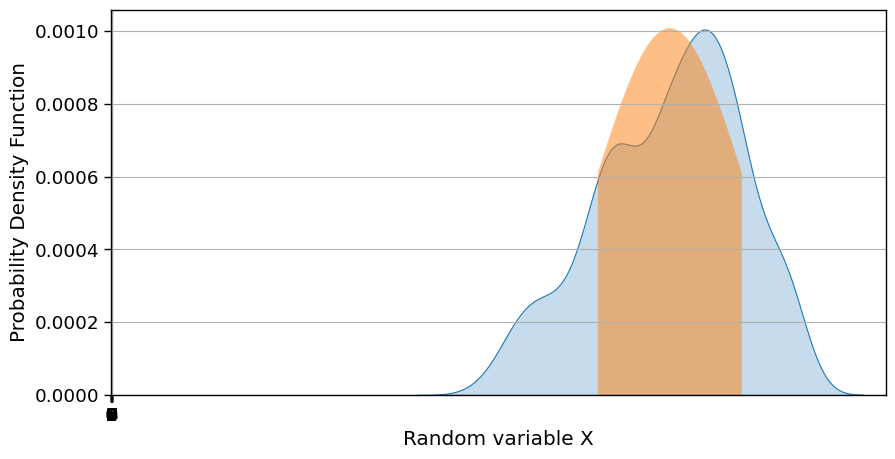

In [100]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

# Line width: Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)
sns.set_context("paper", font_scale=1.5)

# Distribution
X=df["average_number_of_calories_available_per_person_per_day"]
mean = np.mean(X)
var = np.var(X)
std = np.std(X)

print("Mean:", mean)
print("Variance:", var)
print("Standard Deviation:", std)


plt.figure(figsize=(10, 5))

ax = sns.kdeplot(X, shade=True)

# Plot 1-std
x = np.linspace(mean - std, mean + std)
y = norm.pdf(x, mean, std)
ax.fill_between(x, y, alpha=0.5)

plt.xlabel("Random variable X")
plt.ylabel("Probability Density Function")
plt.xticks(ticks=range(0, 10))
plt.grid()

plt.show()